In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import itertools
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.INFO)

### Exploratory data analysis

In [95]:
# Import data
full_data = pd.read_csv("X.csv")
train_y = pd.read_csv("ytr.csv")
# Rename columns to something more interpretable
columns = (["reflectance_" + str(i) for i in range(7)]
           + ["solar_" + str(i) for i in range(5)] + ["id"])
full_data.columns = columns
# Add y to the data frame
split = 98000
y_id_dict = train_y.set_index("Id")["y"].to_dict()
full_data.loc[:(split-1), "y"] = full_data.loc[:(split-1), "id"].replace(y_id_dict)

print(full_data.shape)
full_data.head()

(136400, 14)


,reflectance_0,reflectance_1,reflectance_2,reflectance_3,reflectance_4,reflectance_5,reflectance_6,solar_0,solar_1,solar_2,solar_3,solar_4,id,y
0,1.580642,2.482233,5.887092,4.732722,4.408482,3.830171,4.388508,22.572888,63.58724,88.05048,4.495216,-50.699904,1,-3.998082
1,2.338455,3.627796,4.723716,3.324726,2.743442,4.727652,2.810193,22.572888,63.58724,88.05048,4.495216,-50.699904,1,-3.998082
2,2.224569,3.522241,6.188831,4.389783,4.177616,4.945918,4.122848,22.572888,63.58724,88.05048,4.495216,-50.699904,1,-3.998082
3,1.717218,2.712012,5.024211,3.944907,3.393424,3.931973,3.489578,22.572888,63.58724,88.05048,4.495216,-50.699904,1,-3.998082
4,2.378857,3.644976,4.515292,3.223825,2.739952,4.599662,2.781574,22.572888,63.58724,88.05048,4.495216,-50.699904,1,-3.998082


In [9]:
full_data.describe()

,reflectance_0,reflectance_1,reflectance_2,reflectance_3,reflectance_4,reflectance_5,reflectance_6,solar_0,solar_1,solar_2,solar_3,solar_4,id,y
count,136400.000000,136400.000000,136400.000000,136400.000000,136400.000000,136400.000000,136400.000000,136400.000000,136400.000000,136400.000000,136400.000000,136400.000000,136400.000000,98000.000000
mean,3.913878,5.520243,5.874010,3.884362,3.414531,6.371066,3.539732,17.038353,75.095701,80.918968,3.372937,4.608430,682.500000,-3.427670
std,2.581771,2.954813,2.910327,1.183605,1.852887,3.079436,1.444752,8.768844,10.257322,7.859134,5.474613,50.736762,393.754221,1.313037
min,0.055129,0.101590,0.328379,1.727813,0.695052,0.224890,1.039088,2.933392,53.029500,49.068100,-5.802800,-63.411300,1.000000,-6.479253
25%,2.150606,3.658397,3.772314,3.048089,2.111455,4.431700,2.465407,8.414720,67.169990,75.916542,-1.560051,-51.575395,341.750000,-4.357022
50%,3.395429,5.527791,5.979450,3.711960,2.934214,6.675579,3.313554,16.271903,74.488590,82.493514,3.514780,50.743720,682.500000,-3.554825
75%,5.357954,7.356837,8.107267,4.441237,4.223829,8.715086,4.209915,25.214222,83.905438,86.994045,7.571248,51.919605,1023.250000,-2.649358
max,16.926378,19.640534,20.778873,18.516472,19.187753,19.425559,18.651905,34.159200,96.573215,93.840696,14.479156,76.145400,1364.000000,1.041753


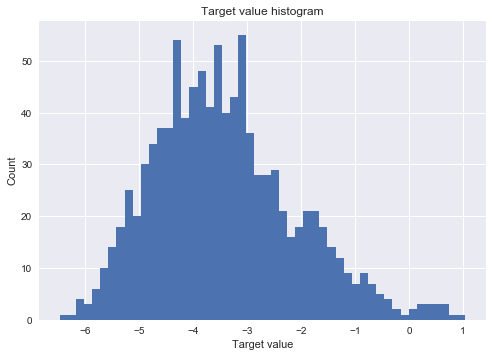

In [3]:
# Plot histogram of y unique values (without the last value which is NaN)
plt.hist(full_data["y"].unique()[:-1], bins=50)
plt.title("Target value histogram")
plt.xlabel("Target value")
plt.ylabel("Count")
plt.show()

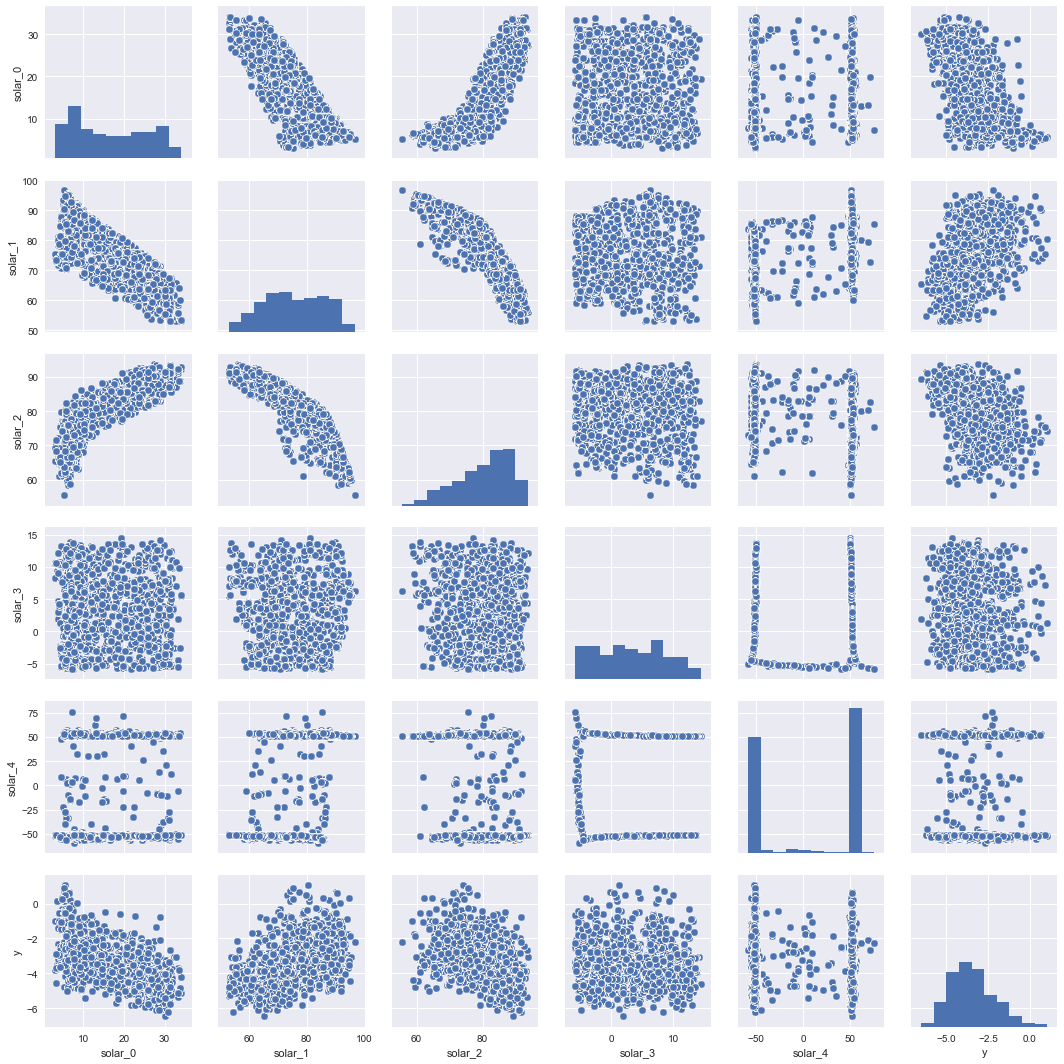

In [65]:
# Bivariate relation of each solar features and target value
sns.pairplot(full_data.loc[:(split-1), ["solar_" + str(i) for i in range(5)] + ["y"]])

* solar_4 has two distinct zones: at -50 and at +50: create a categorical variable to account for that.

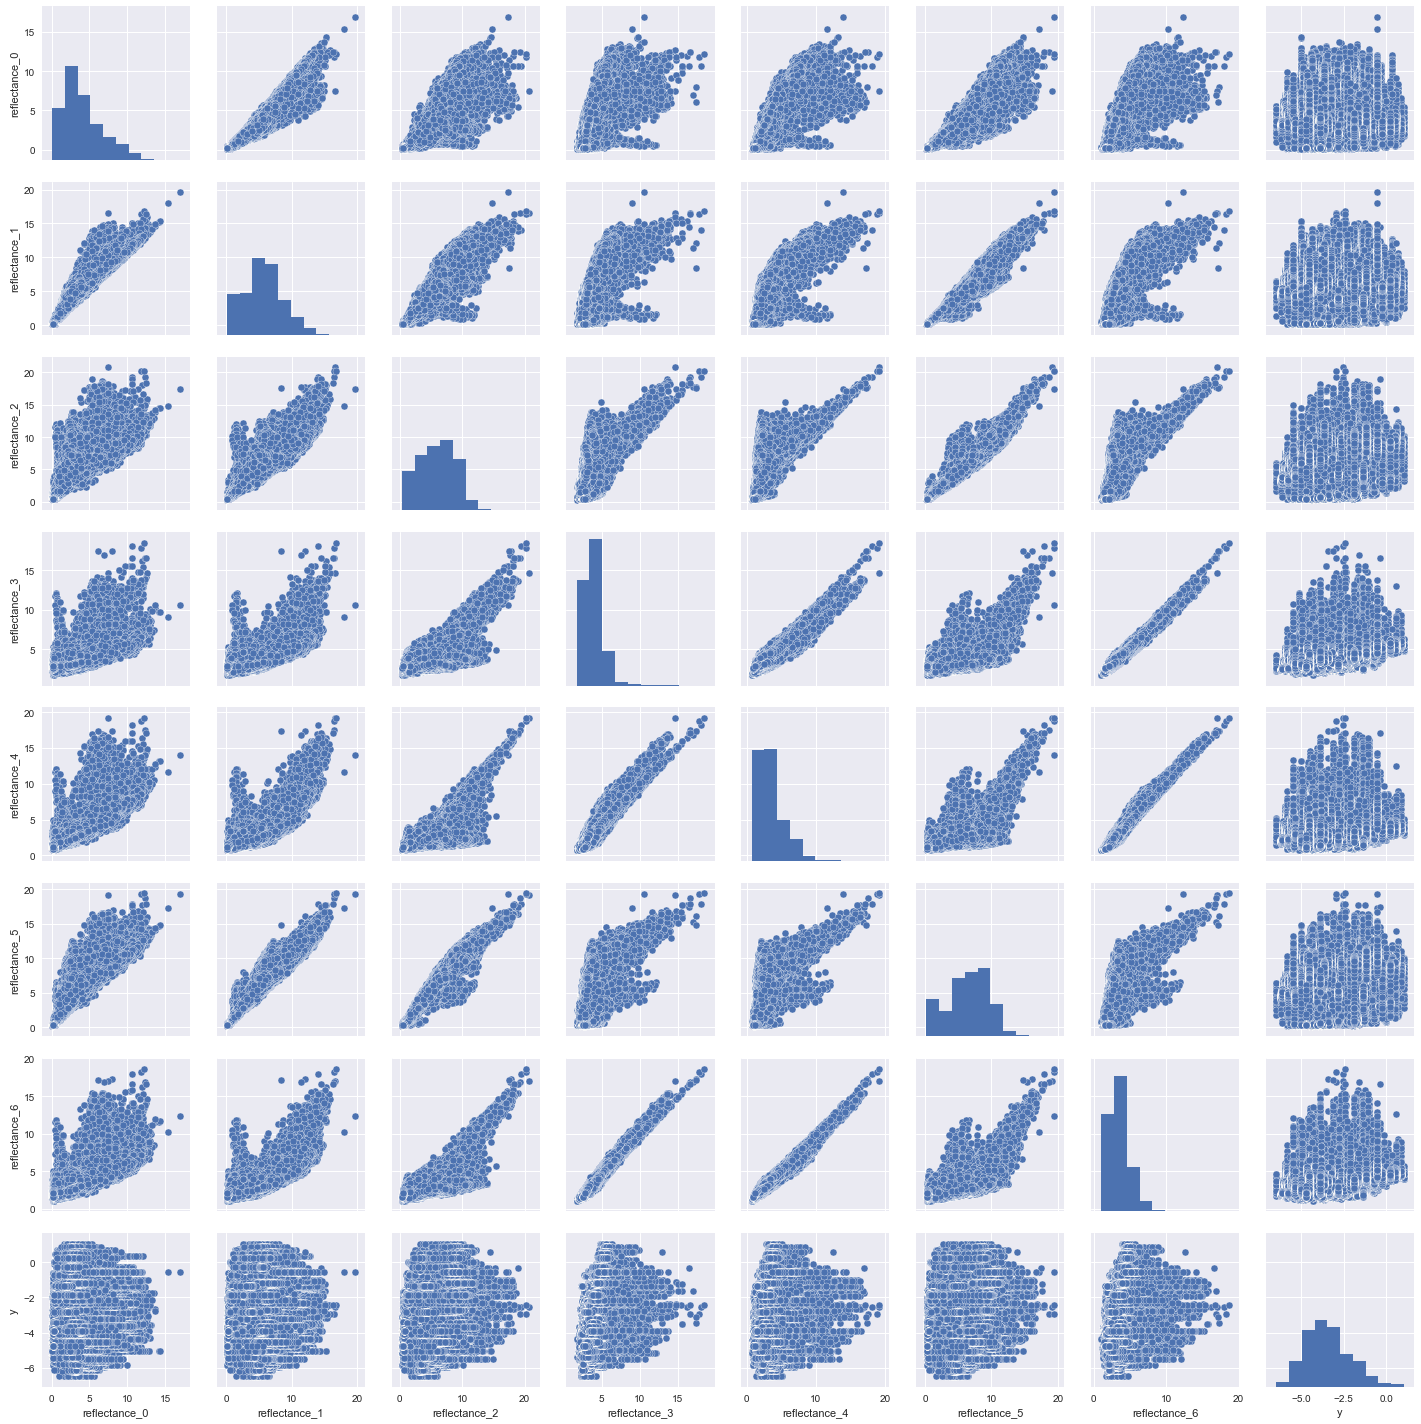

In [68]:
# Bivariate relation of each reflectance features
sns.pairplot(full_data.loc[:(split-1), ["reflectance_" + str(i) for i in range(7)] + ["y"]])

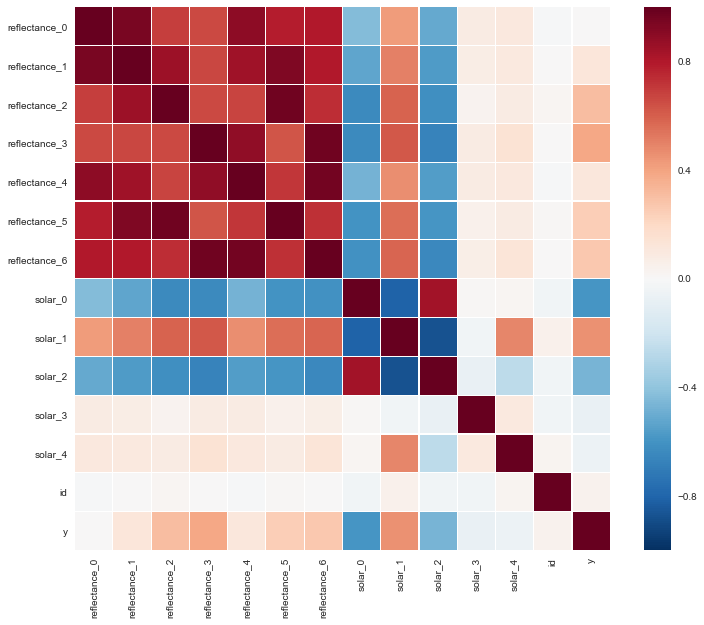

In [14]:
cor_matrix = full_data[:split].corr()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cor_matrix, linewidths=0.2, ax=ax)

In [2]:
# Import data
def load_data():
    full_data = pd.read_csv("X.csv")
    train_y = pd.read_csv("ytr.csv")
    # Rename columns to something more interpretable
    columns = (["reflectance_" + str(i) for i in range(7)]
               + ["solar_" + str(i) for i in range(5)] + ["id"])
    full_data.columns = columns
    # Add y to the data frame
    split = 98000
    y_id_dict = train_y.set_index("Id")["y"].to_dict()
    full_data.loc[:(split-1), "y"] = full_data.loc[:(split-1), "id"].replace(y_id_dict)

    train, test = full_data[:split], full_data[split:]
    return (train, test)

#columns = (["id"] + ["reflectance_" + str(i) for i in range(7)]
#           + ["solar_" + str(i) for i in range(5)] + ["y"])
#full_data = pd.read_csv("MODIS.csv", header=None, names=columns)
#split = 98000
#train, test = full_data[:split].copy(), full_data[split:].copy()
train, test = load_data()

In [3]:
cols_excl = ["id", "y"]
cols_orig = [c for c in train.columns if c not in cols_excl]
outliers_threshold = 0.01

cols_lr0 = cols_orig

models_weights = {"lr0": 1.0}
models_cols = {"lr0": cols_lr0}

plotting_id = 7
y_hat_list = []
RMSE_list = []

# Scoring function in the hyperopt hyperparameters tuning.
def plot_pruning():
    if (True):
        train_fold = train.copy()

        model_lr0 = LinearRegression()
        model_lr0.fit(train_fold[cols_lr0], train_fold["y"])

        models = {"lr0": model_lr0}

        train_pred = train_fold[["id"]].assign(y_hat=0)
        for i, m in models.items():
            train_pred["y_hat"] += models_weights[i] * m.predict(train_fold[models_cols[i]])
        
        y_hat_list.append(train_pred["y_hat"][train_pred["id"] == plotting_id].values)
        
        # Use median value by id
        y_hat_med = train_pred.groupby("id").median()["y_hat"].to_dict()

        RMSE = np.sqrt(mean_squared_error(train_pred["id"].replace(y_hat_med).values, train_fold["y"]))
        RMSE_list.append(RMSE)
        
        # Prune outliers
        RMSE_decreasing = True
        count = 0
        while (RMSE_decreasing):
            count +=1
            if ((count % 5) == 0):
                print(count)
            train_pred["y_med"] = train_pred["id"].replace(y_hat_med)

            # Distance from the median for each bag
            train_pred["score"] = (train_pred["y_hat"] - train_pred["y_med"])**2
            # Rank of each instance by bag
            train_pred["rank"] = train_pred.groupby("id")["score"].rank()
            bag_size_dict = train_pred.groupby("id")["score"].count().to_dict()
            train_pred["bag_size"] = train_pred["id"].replace(bag_size_dict)
            train_pred["rank"] = train_pred["rank"] / train_pred["bag_size"]

            # Remove outliers
            outliers_index = train_pred["rank"] > (1 - outliers_threshold)
            train_fold = train_fold.loc[~outliers_index, :].reset_index(drop=True)

            model_lr0 = LinearRegression()
            model_lr0.fit(train_fold[cols_lr0], train_fold["y"])

            models = {"lr0": model_lr0}

            # Compute new RMSE
            train_pred = train_fold[["id"]].assign(y_hat=0)
            
            for i, m in models.items():
                train_pred["y_hat"] += models_weights[i] * m.predict(train_fold[models_cols[i]])
            
            y_hat_list.append(train_pred["y_hat"][train_pred["id"] == plotting_id].values)
            
            # Use median value by id
            y_hat_med = train_pred.groupby("id").median()["y_hat"].to_dict()

            new_RMSE = np.sqrt(mean_squared_error(train_pred["id"].replace(y_hat_med), train_fold["y"]))
            RMSE_list.append(new_RMSE)
            if ((count % 5) == 0):
                print(new_RMSE)

            if (new_RMSE < RMSE):
                RMSE = new_RMSE
            else:
                RMSE_decreasing = False

In [91]:
plot_pruning()

5
0.797593117783
10
0.783288300348
15
0.774532847503
20
0.768223861487
25
0.764337756155


[]

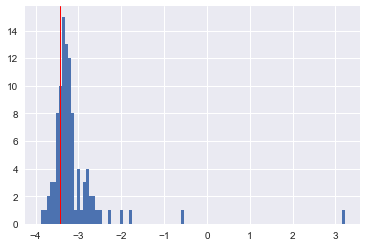

In [92]:
plt.hist(y_hat_list[0], bins=100)
plt.axvline(x=train["y"].unique()[plotting_id - 1], linewidth=1, color="red")
plt.plot()

[]

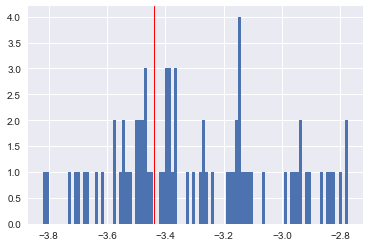

In [93]:
plt.hist(y_hat_list[25], bins=100)
plt.axvline(x=train["y"].unique()[plotting_id - 1], linewidth=1, color="red")
plt.plot() #0.05 threshold

In [73]:
train["id"].unique()[train["y"].unique() > 0]

array([ 93, 101, 216, 232, 236, 309, 423, 488, 525, 647, 685, 748, 909,
       924, 929, 957])

### Predictions with DNN

In [20]:
cols_excl = ["id", "y"]
cols_orig = [c for c in train.columns if c not in cols_excl]
outliers_threshold = 0.05

cols_dnn = cols_orig

models_weights = {"dnn": 1.0}
models_cols = {"dnn": cols_dnn}
nb_neurons_1 = 10
nb_steps = 2000

plotting_id = 7
y_hat_list = []
RMSE_list = []
def pruning_dnn():
    if (True):
        train_fold = train.copy()

        #model_lr0 = LinearRegression()
        #model_lr0.fit(train_fold[cols_lr0], train_fold["y"])
        feature_cols = [tf.contrib.layers.real_valued_column(k) for k in cols_dnn]
        
        # Tune number of layers
        model_dnn = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols,
                                                  hidden_units=[nb_neurons_1])
                                                                #parameters["nb_neurons_2"]],
                                                  #optimizer=tf.train.ProximalAdagradOptimizer(
                                                   #   learning_rate=0.1,
                                                    #  l1_regularization_strength=0.001),
                                                  #model_dir=model_dir)

        def input_fn(data_set):
            feature_cols = {k: tf.constant(data_set[k].values) for k in cols_dnn}
            labels = tf.constant(data_set["y"].values)
            return feature_cols, labels
        
        model_dnn.fit(input_fn=lambda: input_fn(train_fold), steps=nb_steps)
        models = {"dnn": model_dnn}

        train_pred = train_fold[["id"]].assign(y_hat=0)
        for i, m in models.items():
            temp = m.predict(input_fn=lambda: input_fn(train_fold))
            # .predict() returns an iterator; convert to an array
            y_hat = np.array(list(itertools.islice(temp, 0, None)))
            train_pred["y_hat"] += models_weights[i] * y_hat
            
        y_hat_list.append(train_pred["y_hat"][train_pred["id"] == plotting_id].values)

        # Use median value by id
        y_hat_med = train_pred.groupby("id").median()["y_hat"].to_dict()

        RMSE = np.sqrt(mean_squared_error(train_pred["id"].replace(y_hat_med).values, train_fold["y"]))
        
        RMSE_list.append(RMSE)
        
        # Prune outliers
        RMSE_decreasing = True
        count = 0
        while (RMSE_decreasing):
            count +=1
            if ((count % 2) == 0):
                print(count)
            train_pred["y_med"] = train_pred["id"].replace(y_hat_med)

            # Distance from the median for each bag
            train_pred["score"] = (train_pred["y_hat"] - train_pred["y_med"])**2
            # Rank of each instance by bag
            train_pred["rank"] = train_pred.groupby("id")["score"].rank()
            bag_size_dict = train_pred.groupby("id")["score"].count().to_dict()
            train_pred["bag_size"] = train_pred["id"].replace(bag_size_dict)
            train_pred["rank"] = train_pred["rank"] / train_pred["bag_size"]

            # Remove outliers
            outliers_index = train_pred["rank"] > (1 - outliers_threshold)
            train_fold = train_fold.loc[~outliers_index, :].reset_index(drop=True)

            #model_lr0 = LinearRegression()
            #model_lr0.fit(train_fold[cols_lr0], train_fold["y"])
            model_dnn = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols,
                                                      hidden_units=[nb_neurons_1])
                                                                    #parameters["nb_neurons_2"]],
                                                      #optimizer=tf.train.ProximalAdagradOptimizer(
                                                       #   learning_rate=0.1,
                                                        #  l1_regularization_strength=0.001),
                                                      #model_dir=model_dir)

            model_dnn.fit(input_fn=lambda: input_fn(train_fold), steps=nb_steps)

            models = {"dnn": model_dnn}

            # Compute new RMSE
            train_pred = train_fold[["id"]].assign(y_hat=0)
            
            for i, m in models.items():
                temp = m.predict(input_fn=lambda: input_fn(train_fold))
                # .predict() returns an iterator; convert to an array
                y_hat = np.array(list(itertools.islice(temp, 0, None)))
                train_pred["y_hat"] += models_weights[i] * y_hat
                
            y_hat_list.append(train_pred["y_hat"][train_pred["id"] == plotting_id].values)

            # Use median value by id
            y_hat_med = train_pred.groupby("id").median()["y_hat"].to_dict()

            new_RMSE = np.sqrt(mean_squared_error(train_pred["id"].replace(y_hat_med), train_fold["y"]))
            RMSE_list.append(new_RMSE)
            if ((count % 2) == 0):
                print(new_RMSE)

            if (new_RMSE < RMSE):
                RMSE = new_RMSE
            else:
                RMSE_decreasing = False

In [21]:
pruning_dnn()

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x112bbd250>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/l1/n4xw1wl

[]

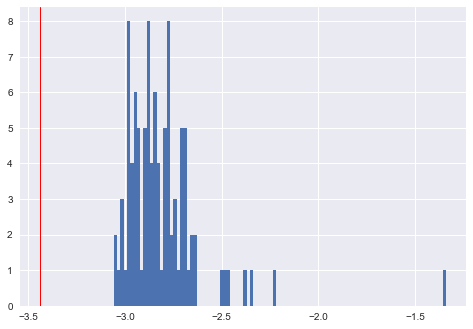

In [23]:
plt.hist(y_hat_list[0], bins=100)
plt.axvline(x=train["y"].unique()[plotting_id - 1], linewidth=1, color="red")
plt.plot()

[]

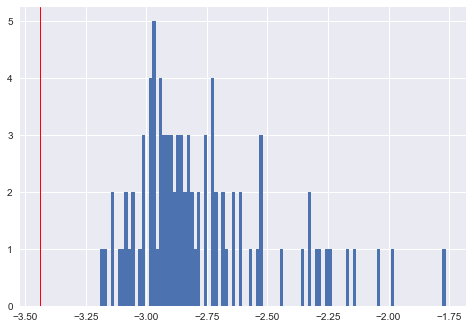

In [25]:
plt.hist(y_hat_list[2], bins=100)
plt.axvline(x=train["y"].unique()[plotting_id - 1], linewidth=1, color="red")
plt.plot()

In [22]:
RMSE_list

[0.95955766591248404, 0.94345244209755075, 0.95782780805922041]